## Day 3 Part I
### Agenda
1. [**Segmentation with Cellpose**](#segmentation-with-cellpose)
2. [**Denoising with Cellpose**](#denoising-with-cellpose)
3. [**Retraining a Cellpose Model**](#retraining-a-cellpose-model)
4. [**Segmenting with StarDist**](#stardist)
2. [**Tracking**](#tracking)

## Segmentation with Cellpose
<a name=cellpose></a>

Classical computer vision (covered in day 2 of the boot camp) allowed us to segment cells automatically in many cases. However, there can be significant fine tuning and knowledge requirements to attain proper segmentation. Thanks to the machine learning we can use open source, pre-trained models to automatically segment cell images for us.
\
\
The current state of the art machine learning segmentation package is cellpose. Cellpose has publicly available generalist models that achieves average accuracy of 80% segmentation. This section of the bootcamp will teach you how to use cellpose in a colab notebook

*(Portions of code in this module are based off of CellPose example Colab Notebooks available on their github page)*

### Installation

In [ ]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!pip install moviepy

In [4]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Jun_13_19:16:58_PDT_2023
Cuda compilation tools, release 12.2, V12.2.91
Build cuda_12.2.r12.2/compiler.32965470_0


Thu Jun 13 14:45:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     Off | 00000000:19:00.0 Off |                  N/A |
| 30%   29C    P8               8W / 250W |      6MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cellpose import utils, io
from cellpose.models import Cellpose
import numpy as np

mpl.rcParams["figure.dpi"] = 100

In [4]:
from cellpose.core import use_gpu

# check if the notebook is using GPU
use_gpu = use_gpu()
print(use_gpu)

True


### Load images

In [8]:
url = "http://www.cellpose.org/static/data/imgs_cyto3.npz"
filename = "imgs_cyto3.npz"
utils.download_url_to_file(url, filename)
data = np.load(filename, allow_pickle=True)["arr_0"].item()

  0%|          | 0.00/21.3M [00:00<?, ?B/s]

100%|██████████| 21.3M/21.3M [00:00<00:00, 36.0MB/s]


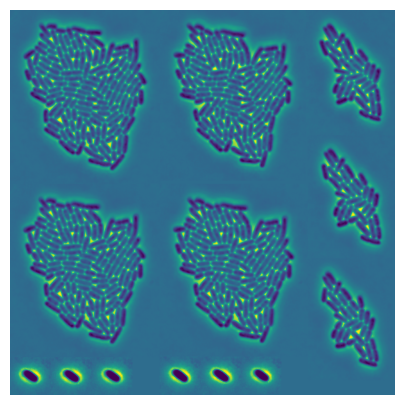

In [41]:
# Create a slider to choose which image you want to analyze
image_index = 17  # @param {type:"slider", min:0, max:23, step:1}

image = data["imgs"][image_index]
masks_true = data["masks_true"][image_index]

if image[1].sum() == 0:
    rgb_image = image[0]

    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(rgb_image)
    ax.axis("off")
else:
    rgb_image = np.concatenate((np.zeros_like(image)[:1], image), axis=0)
    rgb_image = rgb_image.transpose((1, 2, 0))
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image[0, :, :])
    ax[0].axis("off")
    ax[1].imshow(image[1, :, :])
    ax[1].axis("off")

    plt.tight_layout()

### Running Cellpose pre-trained models

Celllpose has several pre-trained models available for use. The most commonly used one is 'cyto3' which is a generalist model used for cytoplasm segmentation. This model can be used to segment a wide range of cell types. More information on more specific models offered by cellpose is [availble in the cellpose docs](https://cellpose.readthedocs.io/en/latest/models.html).

In [42]:
# get text output for the progress of cellpose
io.logger_setup()

model = Cellpose(gpu=use_gpu, model_type="cyto3")

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
# OR if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]

# First we run the cellpose model with grayscale detection only by setting channels
# To channels = [0,0]
masks_pred_grayscale, flows, styles, diams = model.eval(
    [image], diameter=0, channels=[0, 0], niter=2000
)

# Next we run cellpose on cytoplasm and nucleus data using channels = [1,2]
if image[1].sum() != 0:
    masks_pred_color, flows, styles, diams = model.eval(
        [image], diameter=0, channels=[1, 2], niter=2000
    )
else:
    masks_pred_color = masks_pred_grayscale

2024-06-18 11:15:03,339 [INFO] WRITING LOG OUTPUT TO /home/cherr/.cellpose/run.log
2024-06-18 11:15:03,339 [INFO] 
cellpose version: 	3.0.9 
platform:       	linux 
python version: 	3.10.14 
torch version:  	2.3.1+cu121
2024-06-18 11:15:03,357 [INFO] ** TORCH CUDA version installed and working. **
2024-06-18 11:15:03,358 [INFO] >>>> using GPU
2024-06-18 11:15:03,359 [INFO] >> cyto3 << model set to be used
2024-06-18 11:15:03,416 [INFO] >>>> loading model /home/cherr/.cellpose/models/cyto3
2024-06-18 11:15:03,484 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-18 11:15:03,485 [INFO] channels set to [0, 0]
2024-06-18 11:15:03,486 [INFO] ~~~ ESTIMATING CELL DIAMETER(S) ~~~
2024-06-18 11:15:07,204 [INFO] estimated cell diameter(s) in 3.72 sec
2024-06-18 11:15:07,205 [INFO] >>> diameter(s) = 
2024-06-18 11:15:07,205 [INFO] [15.72, ]
2024-06-18 11:15:07,206 [INFO] ~~~ FINDING MASKS ~~~
2024-06-18 11:15:08,020 [INFO] >>>> TOTAL TIME 4.53 sec


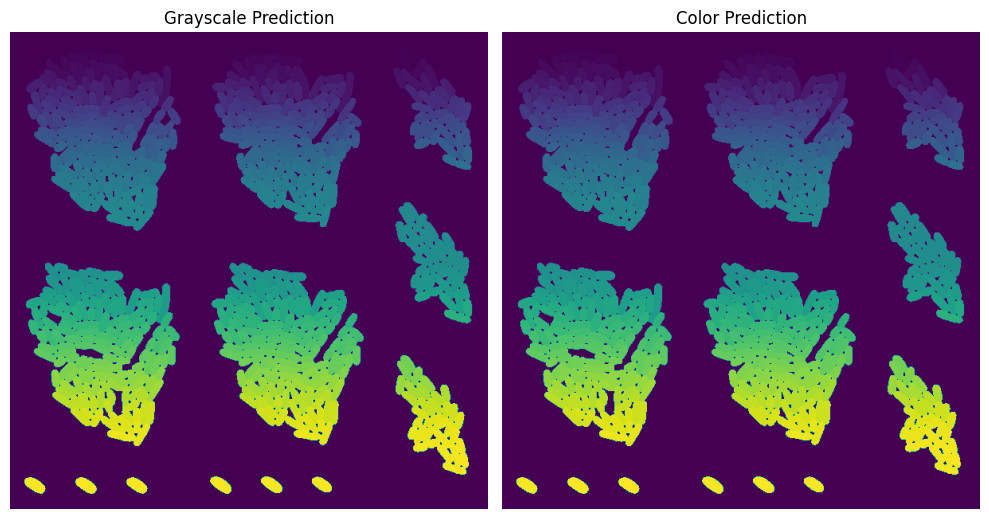

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
ax[0].imshow(masks_pred_grayscale[0])
ax[0].set_title("Grayscale Prediction")
ax[0].axis("off")
ax[1].imshow(masks_pred_color[0])
ax[1].set_title("Color Prediction")
ax[1].axis("off")
plt.tight_layout()

In [44]:
def plot_outlines(label_image, ax=None, **kwargs):
    """ Function to plot outlines of masks

    Args:
        label_image (np.ndarray): label image of masks
        ax (matplotlib.axes.Axes): axes to plot on
        **kwargs: keyword arguments for plotting
    """

    outlines = utils.outlines_list(label_image)

    for o in outlines:
        if ax is None:
            plt.plot(o[:, 0], o[:, 1], **kwargs)
        else:
            ax.plot(o[:, 0], o[:, 1], **kwargs)


(-0.5, 599.5, 599.5, -0.5)

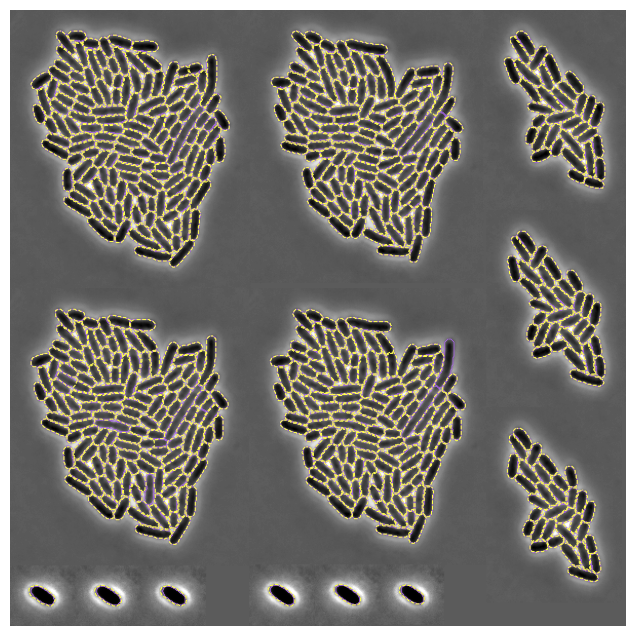

In [46]:
plt.figure(figsize=(8,8))
if rgb_image.shape[0] != 3:
    plt.imshow(rgb_image, cmap="gray")
else:
    plt.imshow(rgb_image)

plot_outlines(masks_true, color=[0.7, 0.4, 1], lw=0.5)
plot_outlines(masks_pred_color[0], color=[1, 1, 0.3], lw=0.75, ls="--")

plt.axis("off")

### Exercise


1. Load one of the images that has a nucleus channel and use the Cellpose nucleus segmentation on it. 
Documentation for the nucleus segmentation can be found at https://cellpose.readthedocs.io/en/latest/models.html#nucleus-model-nuclei. 

    *Hint: you will need to instantiate a new cellpose model*



2. Run Cellpose on your own data or on publicly available data. There are a variety of
publicly availble cell biology datasets that you can pull images from. Some examples can be found at [Broad Bioimage Benchmark Collection](https://bbbc.broadinstitute.org/) and [Cell Tracking Challenge](https://celltrackingchallenge.net/2d-datasets/). For even more data you can visit [CytoData's curated selction](https://github.com/cytodata/awesome-cytodata) of data and software.

In [ ]:
# mount your local google drive to import images and try cellpose
from google.colab import drive

drive.mount("/content/drive")

# load an image from google drive
image_path = "/content/drive/My Drive/your_image.tif"

# Use whatever method necessary to load your image
# example code uses cellpose.io
img = io.imread(image_path)

# run cellpose
# masks, flows, styles, diams = model.eval([], diameter=0, channels=[0,0], invert=False, normalize=True)

## Denoising with Cellpose
<a name=denoising></a>

Cellpose 3.0 introduced machine-learning based denoising for blurry or noisy videos. This can help you get
the most out of limited optical setups. 

In [63]:
# download noisy images from website
url = "http://www.cellpose.org/static/data/test_poisson.npz"
filename = "test_poisson.npz"
utils.download_url_to_file(url, filename)
data_noisy = np.load(filename, allow_pickle=True)["arr_0"].item()

 55%|█████▍    | 15.3M/28.0M [00:00<00:00, 34.1MB/s]

100%|██████████| 28.0M/28.0M [00:00<00:00, 29.8MB/s]


(-0.5, 511.5, 382.5, -0.5)

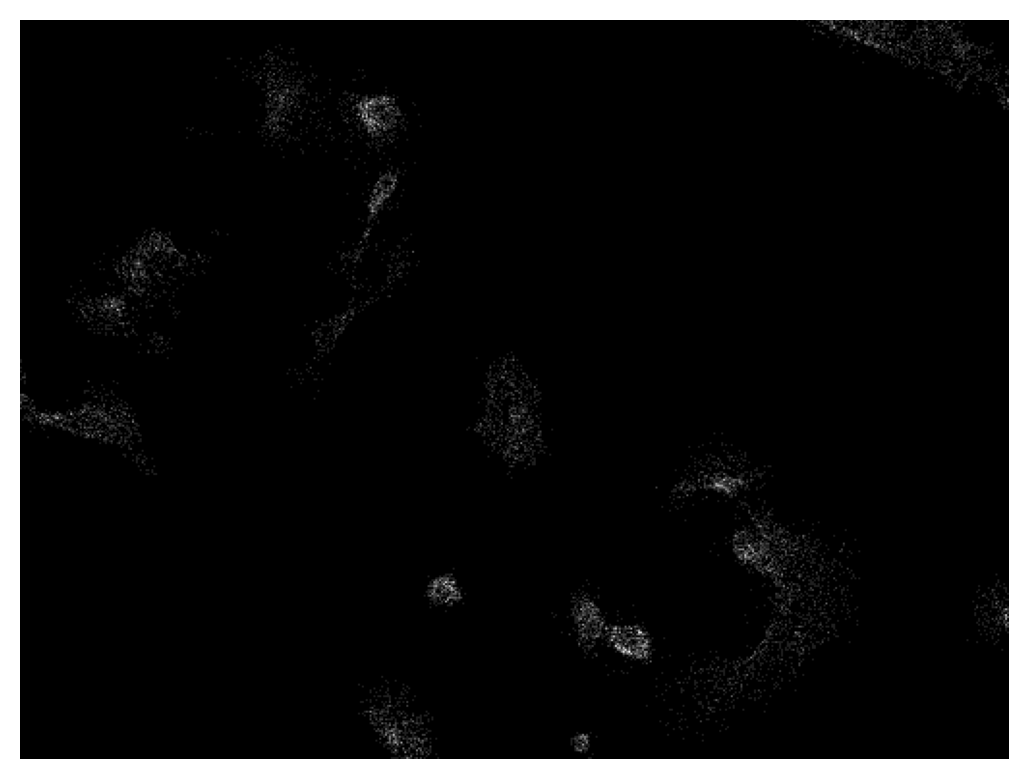

In [65]:
image_index = 10  # @param {type:"slider", min:0, max:67, step:1}

# Load and display the sample image
image_noisy = data_noisy["test_noisy"][image_index].squeeze()
diam = data_noisy["diam_test"][image_index]
plt.imshow(image_noisy, cmap="gray")
plt.axis("off")

In [66]:
from cellpose.denoise import CellposeDenoiseModel

# Create the denoising model
model_denoise = CellposeDenoiseModel(
    gpu=use_gpu, model_type="cyto3", restore_type="denoise_cyto3"
)


# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus
# OR if you have different types of channels in each image
# channels = [[2,3], [0,0], [0,0]]
channels = [0, 0]

# run the denoising model
masks, flows, styles, image_denoised = model_denoise.eval(
    [image_noisy], diameter=diam, channels=channels
)


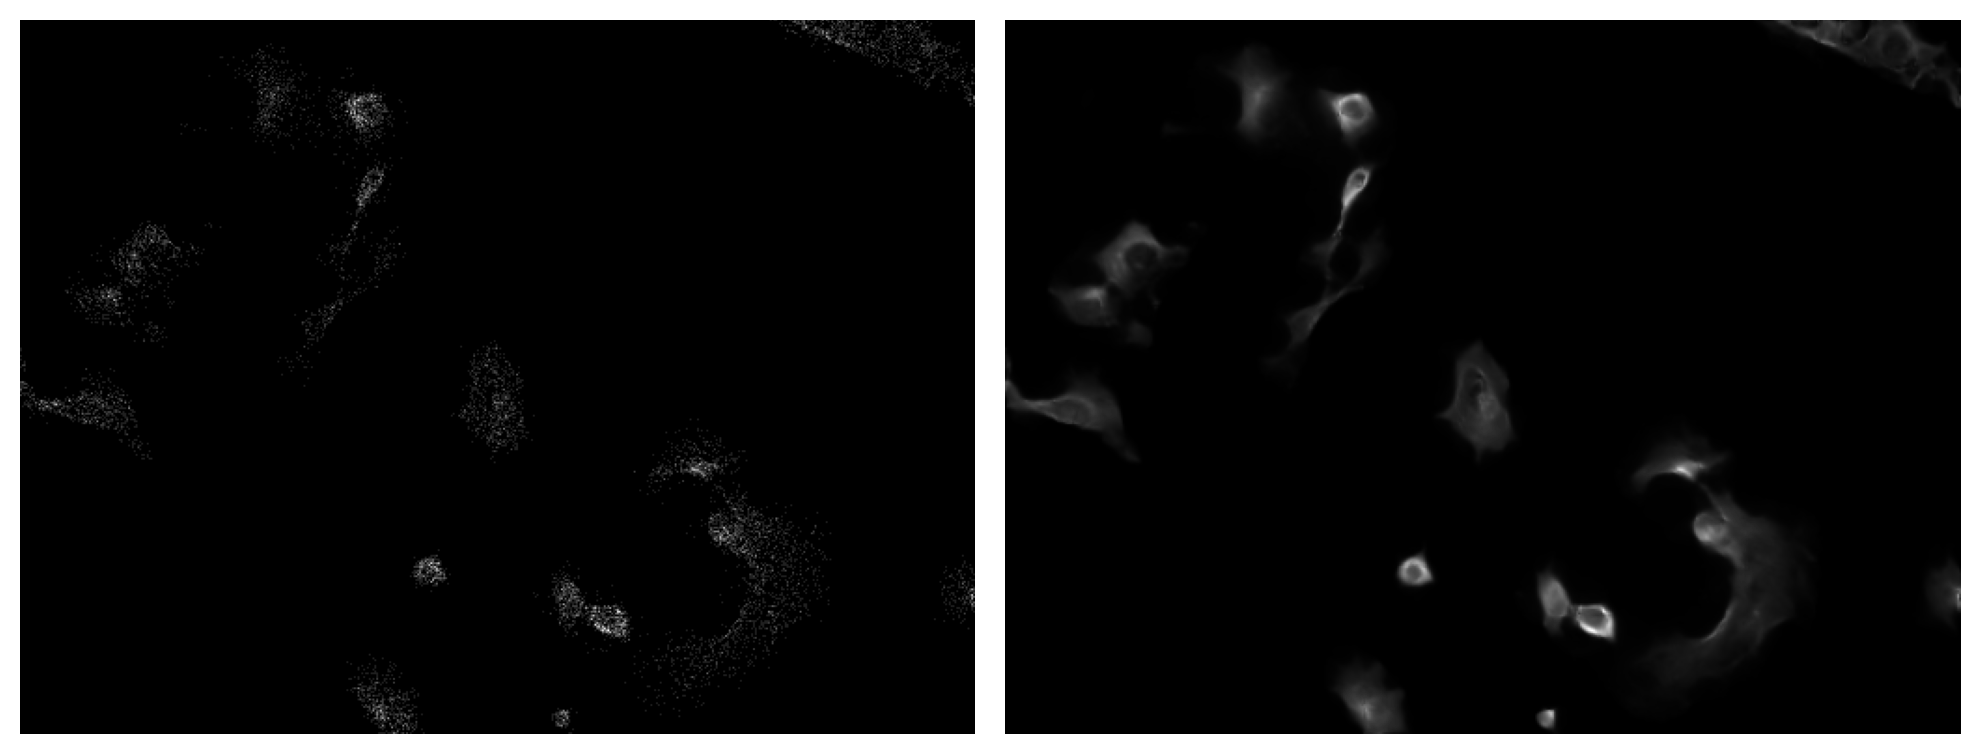

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image_noisy, cmap="gray")
ax[0].axis("off")
ax[1].imshow(image_denoised[0], cmap="gray")
ax[1].axis("off")

plt.tight_layout()

## Retraining a Cellpose Model


In [ ]:
# This step is optional
train_dir = ""
output = io.load_train_test_data(train_dir, test_dir=None, image_filter="_img",
                                mask_filter="_masks", look_one_level_down=False)

images, labels, image_names, test_images, test_labels, image_names_test = output

# you can instead load an array of images and labels yourself and pass them to the training function

In [ ]:
from cellpose import train
from cellpose.models import CellposeModel


model = CellposeModel(model_type="cyto3")

model_path = train.train_seg(model.net, train_data=images, train_labels=labels,
                            channels=[1,2], normalize=True,
                            test_data=test_images, test_labels=test_labels,
                            weight_decay=1e-4, SGD=True, learning_rate=0.1,
                            n_epochs=100, model_name="my_new_model")

## Stardist

Cellpose is a fantastic generalist algorithm, but for some uses it is overkill. If you have a very simple dataset that consists of more round objects you can use [Stardist](https://github.com/stardist/stardist) for automatic detection. 


In [ ]:
!pip install stardist

In [38]:
# Acknowledgement: Code from this section is copied from stardist's github page

from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


Text(0.5, 1.0, 'Stardist Prediction')

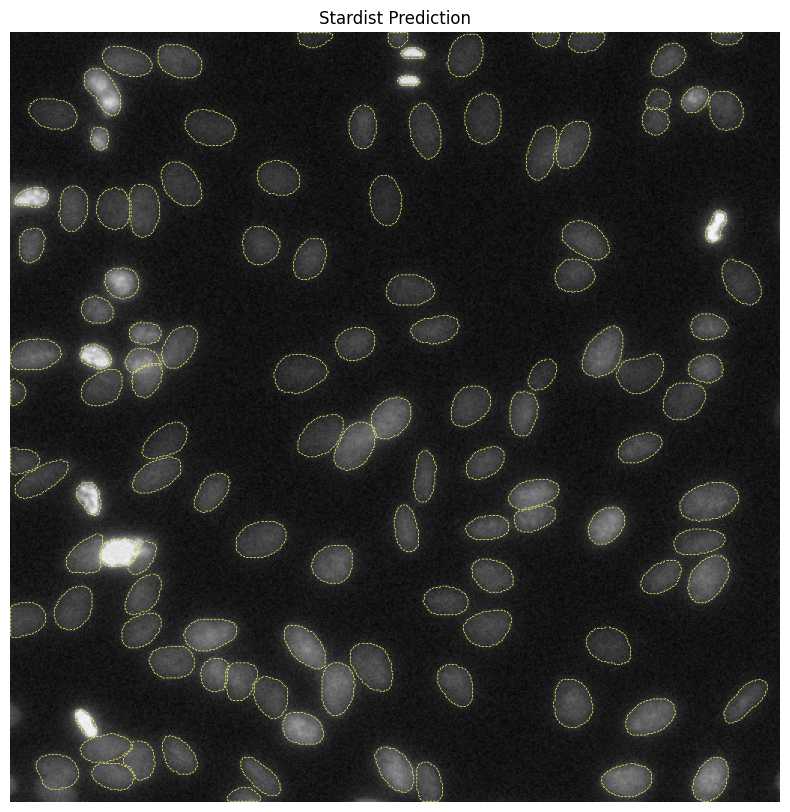

In [40]:
# Acknowledgement: Code from this section is modified from stardist's github page

from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

stardist_test_image = test_image_nuclei_2d()

labels, _ = model.predict_instances(normalize(stardist_test_image))

outlines = utils.outlines_list(labels)


plt.figure(figsize=(10, 10))
plt.imshow(stardist_test_image, cmap="gray")
plot_outlines(labels, color=[1.0, 1.0, .4], lw=0.5, ls ='--')

plt.axis("off")
plt.title("Stardist Prediction")

If we try to run StarDist on some of the earlier cellpose data we see that it fails to adequately capture the full
cell membrane, but it can pretty accurately measure the nuclei

Text(0.5, 1.0, 'Nuclei Prediction')

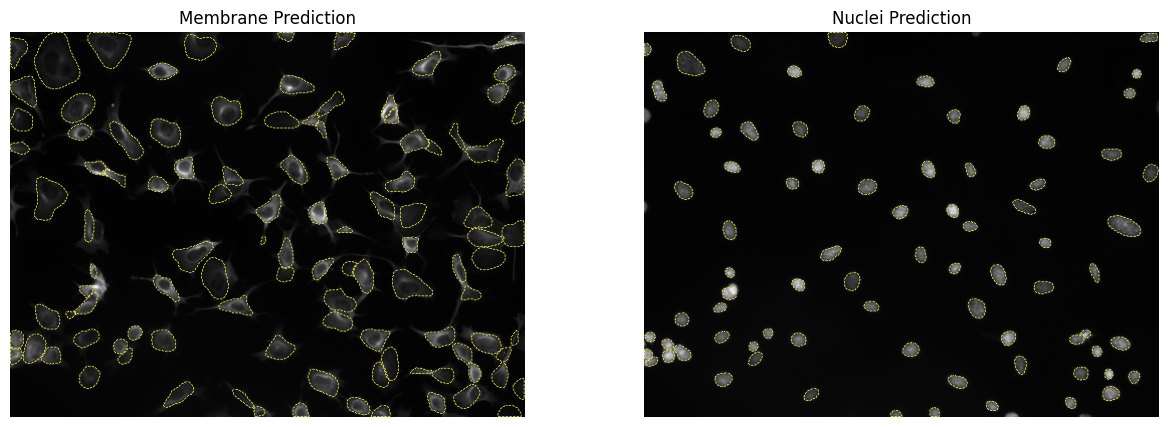

In [48]:
image = data["imgs"][0]

# run stardist
membrane_labels, _ = model.predict_instances(normalize(image[0]))
nuclei_labels, _ = model.predict_instances(normalize(image[1]))


# plot side by side overlayed on the image
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image[0], cmap="gray")
plot_outlines(membrane_labels, ax=ax[0], color=[1.0, 1.0, .4], lw=0.5, ls ='--')
ax[0].axis("off")
ax[0].set_title("Membrane Prediction")

ax[1].imshow(image[1], cmap="gray")
plot_outlines(nuclei_labels, ax=ax[1], color=[1.0, 1.0, .4], lw=0.5, ls ='--')
ax[1].axis("off")
ax[1].set_title("Nuclei Prediction")


## Tracking
<a name=tracking></a>

### Using trackpy

Trackpy is a python library used for tracking blob-like features in videos and following them 
through time. It implements the Crocker-Grier algorithm and allows for feature and trajectory
finding in arbitrarily long videos. Documentation can be [found here](http://soft-matter.github.io/trackpy/v0.6.3/).
 

The basic workflow in trackpy is:
1. Import your cell data and binarize
2. Construct a dataframe containing the position of the cells
3. Link the dataframe together to get trajectories

### Importing cell data and segmenting

First we will download a publicly available timelapse cell dataset [available here](https://zenodo.org/records/5206107)

In [5]:
# !wget "https://zenodo.org/records/5206107/files/P31-crop.tif" --output-document=P31-crop.tif
images = io.imread(filename="P31-crop.tif")

100%|██████████| 86/86 [00:00<00:00, 932.88it/s]


This is a timelapse image of cancer cell migration, which could be useful to automatically segment and track. First we'll display an animation of the data to get an idea of what we are trying to segment.

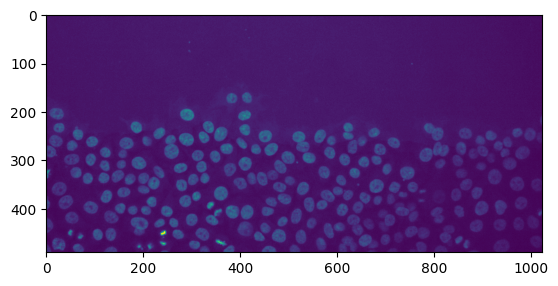

In [9]:
plt.imshow(images[0])

In [6]:
# save the array as a gif
from PIL import Image
from IPython.display import Image as DisplayImage
import os

if './grayscale_images.gif' not in os.listdir():
    grayscale_images = (images/np.max(images)*255).astype(np.uint8)
    imgs = [Image.fromarray(img) for img in grayscale_images]
    # duration is the number of milliseconds between frames; this is 40 frames per second
    imgs[0].save("grayscale_images.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)


![SegmentLocal](./grayscale_images.gif "segment")

In [6]:
model = Cellpose(gpu=use_gpu)
masks_predicted, flow, style, diam = model.eval(
    [images[i] for i in range(images.shape[0])], diameter=0
)
masks_predicted = np.array(masks_predicted)

np.save("masks_predicted.npy", masks_predicted)

In [17]:

# map grayscale predicted masks to rgb using colormap
masks_colored = [plt.cm.viridis(mask) for mask in masks_predicted]
masks_colored = [(mask[:, :, :3]*255).astype(np.uint8) for mask in masks_colored]


# imgs = [Image.fromarray(img) for img in grayscale_images]
# # duration is the number of milliseconds between frames; this is 40 frames per second
# imgs[0].save("grayscale_images.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

In [19]:
# import rgba to rgb
from skimage.color import rgba2rgb

# save the array as a gif
if './segmented_images.gif' not in os.listdir():
    segmented_images = masks_colored
    imgs = [Image.fromarray(img) for img in segmented_images]
    # duration is the number of milliseconds between frames; this is 40 frames per second
    imgs[0].save("segmented_images.gif", save_all=True, append_images=imgs[1:], duration=50, loop=0)

![SegmentLocal](segmented_images.gif "segment")

#### Exercise

1. Use stardist to segment the above movie and plot the result. (Save the result under a different variable name for future use)

### Creating pandas dataframe

In [12]:
import pandas as pd
from skimage.measure import regionprops_table

We have already binarized the image in the above step, next we will construct a dataframe to feed to trackpy.

At minimum, the dataframe needs to contain a column for the x, y, and time coordinates for each cell you wish to track
at every single point in time.

In [16]:
props = pd.DataFrame()
for frame in range(masks_predicted.shape[0]):
    # Use regionprops_table to get the centroid and area of each mask
    # note that you can get as many cell morphology properties as you want
    # see skimage documentation for more options (e.g. eccentricity, solidity, etc.)
    props_tmp = regionprops_table(
        masks_predicted[frame], properties=("label", "centroid", "area")
    )
    props_tmp = pd.DataFrame(props_tmp)

    # Add the frame number to the dataframe
    props_tmp["frame"] = frame

    props = pd.concat([props, props_tmp])

# Display the first few rows of the dataframe
props.head()

,label,centroid-0,centroid-1,area,frame
0,1,172.179894,414.552910,378.0,0
1,2,173.399533,383.149533,428.0,0
2,3,204.632280,21.519135,601.0,0
3,4,206.928814,291.011864,590.0,0
4,5,208.250000,409.458716,436.0,0


### Linking the dataframe

The final step is to actually track the individual cells using ```tp.link```.

The linking function creates a new dataframe with one additional column named ```particle```. The ```particle```
column contains an id that associates every row with a unique particle track.

In [24]:
import trackpy as tp

# we have to tell trackpy which columns correspond to the y, x, and time coordinates
tracks = tp.link(
    props,
    search_range=10,
    memory=0,
    pos_columns=["centroid-1", "centroid-0"],
    t_column="frame",
)

Frame 85: 285 trajectories present.


Once we have the tracks dataframe we can visualize it by looping over all the unique particles

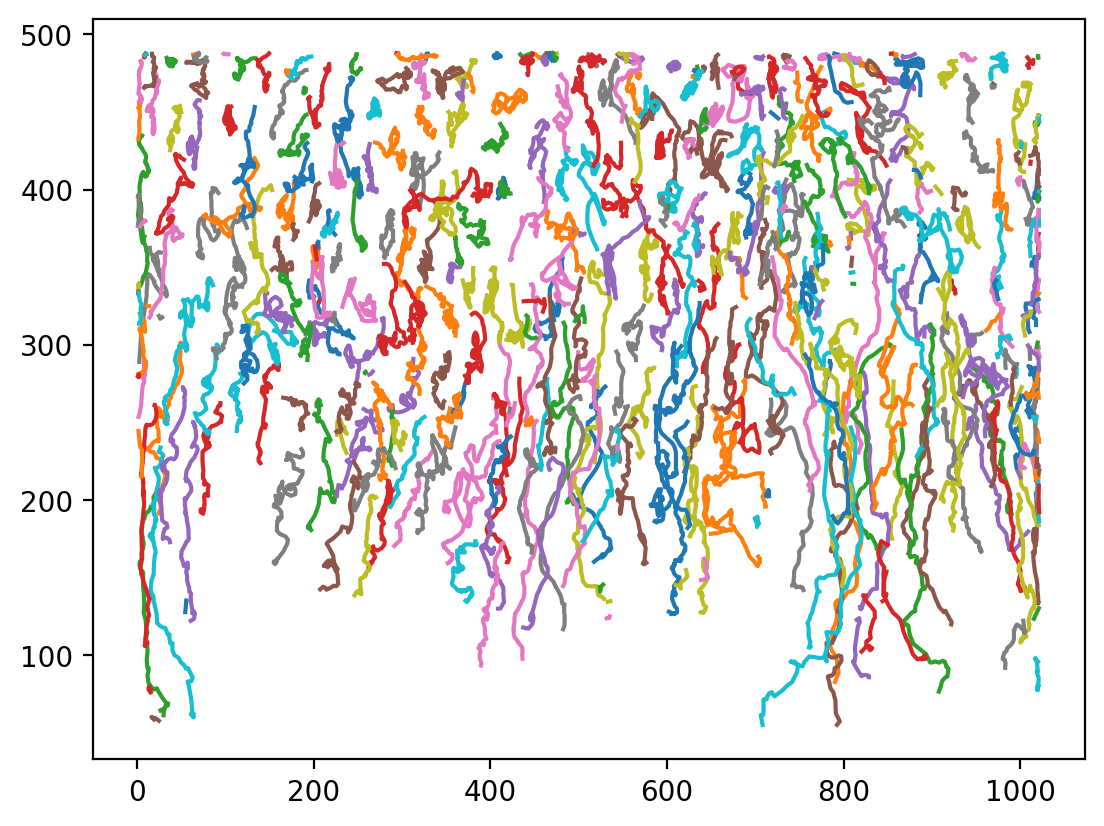

In [26]:
for particle in tracks["particle"].unique():
    plt.plot(
        tracks.query("particle == @particle")["centroid-1"],
        tracks.query("particle == @particle")["centroid-0"],
    )

In order to ensure high quality tracks you sometimes need to filter out spurious tracks 
(tracks that only last a small amount of frames).
This can easily be done with ```trackpy.filtering.filter_stubs()```

Before filtering: 557 particles, after filtering: 186 particles


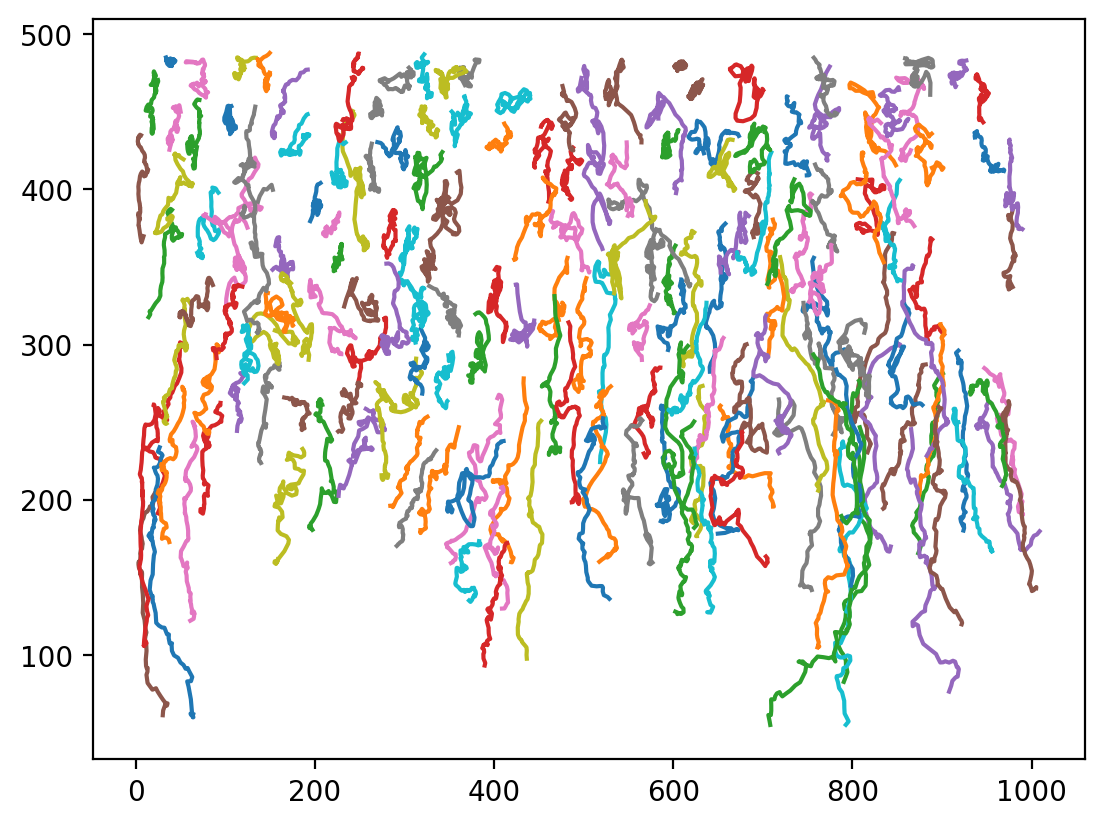

In [31]:
tracks_filtered = tp.filtering.filter_stubs(tracks, threshold=70)
print(
    f'Before filtering: {tracks["particle"].nunique()} particles, after filtering: {tracks_filtered["particle"].nunique()} particles'
)
for particle in tracks_filtered["particle"].unique():
    plt.plot(
        tracks_filtered.query("particle == @particle")["centroid-1"],
        tracks_filtered.query("particle == @particle")["centroid-0"],
    )

### Exercise

1. Calculate the x and y velocity of the tracks we found above and visualize them using matplotlib or seaborn

2. Use trackpy to track cells in your own data from the above exercise (or locate publicly available time series data). 

    Some example metrics to explore are:
    - Average velocity over time
    - Average cell area/circularity/eccentricity over time
    - A distribution of the cell area/circularity/eccentricity


https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki